# **Проект предсказания стоимости поддержанного автомобиля**

## ***Цели и задачи проекта:***

Необходимо построить модель, которая будет предсказывать стоимость автомобиля на вторичном рынке. 
Для оценки качества моделей применяем метрику MAPE.


***План работы:***

- Проведем исследовательский анализ данных
- Осуществим предобработку данных
- Cгенерируем новые признаки для МО
- Подготовим данные для машинного обучения
- Построим несколько моделей-регрессоров
- Определим лучшую метрикой МАРЕ
- Проверим модель на адыкватность
- Получим предсказание лучшей моделью на тестовой выборке
- Подведем итог проекта, составим рекомендации для заказчика

***Описание данных:***
Нам предоставлены два файла с наборами данных -  train.csv и test.csv. В данных содержится подробная информации о различных характеристиках автомобилей.Train используем для обучения моделей, test - для итогового результата. Пропорции данных 1:4. Также есть образец файла с результатами - это vin автомобиля и предсказанная стоимость автомобиля. По условию исследования, количество наблюдений в файле с результатами должно составлять 110058 строк.


## Импорт и установка библиотек

In [69]:
!pip install vininfo[cli]
from vininfo import Vin

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt 
import warnings
import time
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder,StandardScaler,OneHotEncoder,MinMaxScaler 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

from catboost import CatBoostRegressor


RANDOM_STATE = 42

## Ознакомление с данными

In [70]:
# откроем датафрейм обучающим набором данных
df_train = pd.read_csv('/kaggle/input/cars-price-16-08/train.csv')

In [71]:
# откроем датафрейм обучающим набором данных
df_test = pd.read_csv('/kaggle/input/cars-price-16-08/test.csv')

In [72]:
# создадим функцию получения полной информации об имеющихся в нашем распоряжении датафреймах
def get_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe())
    display(data.describe(include=['object', 'bool']))
    print('Количество дубликатов в выборке:', data.duplicated().sum())

In [73]:
# получим информацию о трейн выборке
get_info(df_train)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
366134,2000,NaN,NaN,NaN,NaN,automatic,1j4gw58n8yc207783,tx,3.4,170094.0,green,gray,huffines chrysler jeep dodge lewisville,2200,Thu Jun 18 2015 04:00:00 GMT-0700 (PDT)
170200,2011,Jeep,Grand Cherokee,Overland,SUV,automatic,1j4rr6gg5bc744546,nj,4.8,53018.0,white,brown,j & s auto haus,25300,Wed Jan 14 2015 01:00:00 GMT-0800 (PST)
54436,2008,Dodge,Ram Pickup 1500,Laramie,Quad Cab,automatic,1d7hu18228s517406,ut,NaN,157392.0,white,—,layton hills chrysler dodge jeep ram,10100,Wed Dec 17 2014 11:30:00 GMT-0800 (PST)
238702,2012,Chevrolet,Volt,Base,hatchback,automatic,1g1ra6e42cu111822,pa,3.7,62205.0,—,gray,ge fleet services for itself/servicer,11400,Fri Jun 12 2015 02:00:00 GMT-0700 (PDT)
7275,2013,Chevrolet,Silverado 1500,LT,Crew Cab,automatic,3gcpkse79dg157490,tx,3.4,66436.0,brown,—,tdaf remarketing,22500,Wed Jan 21 2015 02:00:00 GMT-0800 (PST)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


None

,year,condition,odometer,sellingprice
count,440236.000000,430831.000000,440167.000000,440236.000000
mean,2010.040101,3.425077,68344.421604,13592.209588
std,3.977945,0.949973,53542.203908,9751.479098
min,1982.000000,1.000000,1.000000,1.000000
25%,2007.000000,2.700000,28258.000000,6900.000000
50%,2012.000000,3.600000,52098.000000,12100.000000
75%,2013.000000,4.200000,99272.000000,18200.000000
max,2015.000000,5.000000,999999.000000,230000.000000


,make,model,trim,body,transmission,vin,state,color,interior,seller,saledate
count,432193,432113,431899,429843,388775,440236,440236,439650,439650,440236,440236
unique,92,959,1922,85,2,440236,38,20,17,13025,3597
top,Ford,Altima,Base,Sedan,automatic,2fmdk3jc4bba41556,fl,black,black,nissan-infiniti lt,Tue Feb 10 2015 01:30:00 GMT-0800 (PST)
freq,73708,15454,43853,157639,375061,1,65618,87115,192442,15823,4209


Количество дубликатов в выборке: 0


In [74]:
# получим информацию о тест выборке
get_info(df_test)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
42284,2007,Nissan,Murano,S,SUV,automatic,jn8az08t37w528135,fl,1.9,90988.0,black,black,napleton's hyundai,Thu Mar 05 2015 02:15:00 GMT-0800 (PST)
47768,2013,Ford,Focus,SE,Sedan,automatic,1fadp3f21dl273143,co,3.7,51125.0,black,black,ars/avis budget group,Wed Mar 04 2015 03:00:00 GMT-0800 (PST)
32028,2006,Honda,CR-V,Special Edition,SUV,automatic,shsrd78906u408945,ga,2.3,95475.0,gray,black,gwinnett place honda,Tue Dec 23 2014 13:00:00 GMT-0800 (PST)
34528,2007,Nissan,Altima,2.5,Sedan,automatic,1n4al21e87n431450,fl,2.7,93952.0,red,black,onemain rem/nationwide remarketing,Tue May 26 2015 10:30:00 GMT-0700 (PDT)
24928,2012,Lexus,RX 350,Base,SUV,automatic,2t2zk1ba5cc073755,fl,4.6,30477.0,white,black,lexus financial services,Mon Dec 29 2014 09:30:00 GMT-0800 (PST)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


None

,year,condition,odometer
count,110058.000000,107679.000000,110039.000000
mean,2010.060005,3.423222,68074.331601
std,3.960190,0.951301,53520.988173
min,1982.000000,1.000000,1.000000
25%,2007.000000,2.700000,28313.500000
50%,2012.000000,3.600000,51922.000000
75%,2013.000000,4.200000,98852.500000
max,2015.000000,5.000000,999999.000000


,make,model,trim,body,transmission,vin,state,color,interior,seller,saledate
count,107997,107979,107944,107464,97047,110058,110058,109900,109900,110058,110058
unique,85,824,1496,77,2,110058,38,20,17,7623,2817
top,Ford,Altima,Base,Sedan,automatic,1g6dp567450124779,fl,black,black,"ford motor credit company,llc",Tue Feb 17 2015 01:30:00 GMT-0800 (PST)
freq,18383,3736,11007,39255,93584,1,16295,22006,48176,3858,1039


Количество дубликатов в выборке: 0


## Выводы после ознакомлении с данными

- **Train** 440236 строк и 15 столбцов (включай целевой признак "sellingprice")
- **Test** 110058 строк и 14 столбцов 
- пропуски в большинстве столбов присутствуют в обоих выборках
- столбец "year" - минимальный год регистриции автомобиля 1982, максимальный - 2015
- столбец "make" - марки автомобилей имеют 85 уникальных значений
- столбец "model" - модели автомобилей имеют более 800 уникальных значений, самая популярная марка - Ford (что не удивительно для американского авторынка)
- столбец"odometer" - много авто имееют  пробег - 50000, максимальное значение - миллион миль.
- столбец "transmission" - гораздо чаще встречаются авто с автоматической коробкой передач.
- столбец "state" - говорит нам, что авто проданы в 38 штатах США
- столбец "condition " - оценка состояния авто при продаже, большинство машин имеют среднее состояние.

# ***Обработка пропусков***

In [75]:
# создадим функцию визуализации пропущенных значений
def isnull(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 45, legend = False, fontsize = 16)
            .set_title('Пропущенные значения', fontsize = 25, color = 'Red'));    
    except:
        print('пропусков не осталось :)')

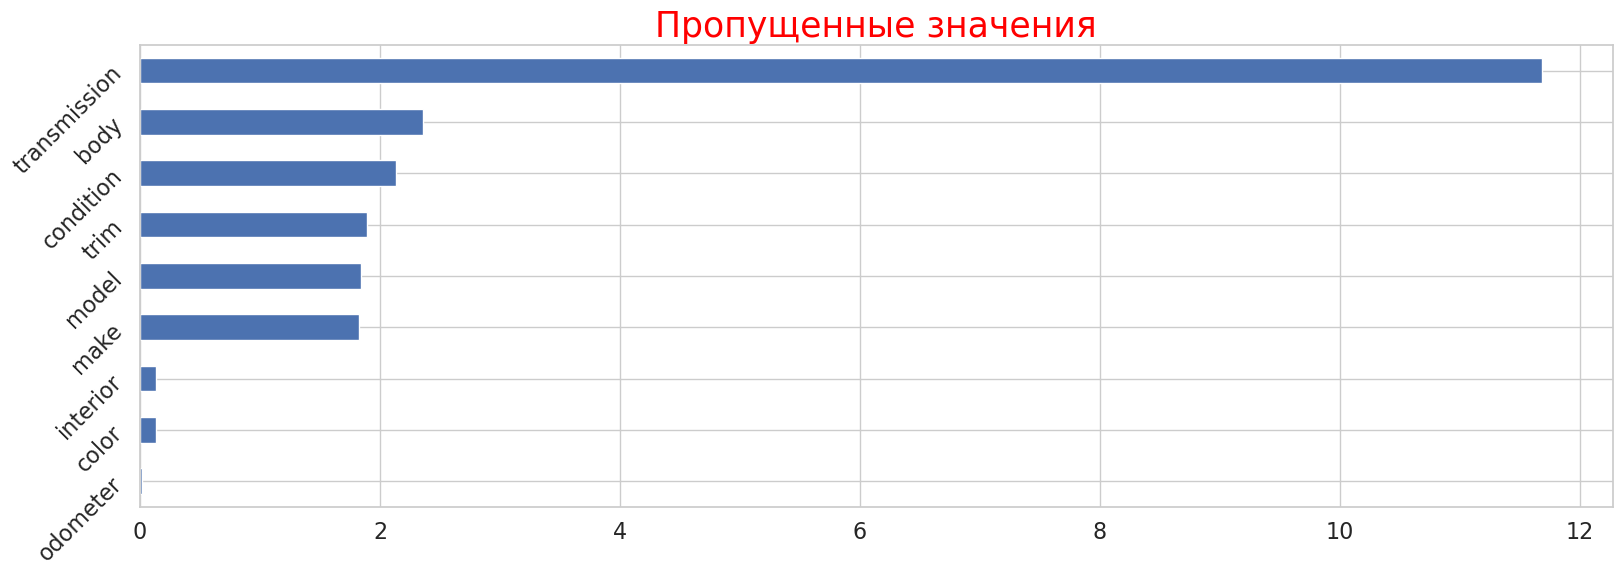

In [76]:
# посмотрим как обстоят дела спропускми в трейне
isnull(df_train)

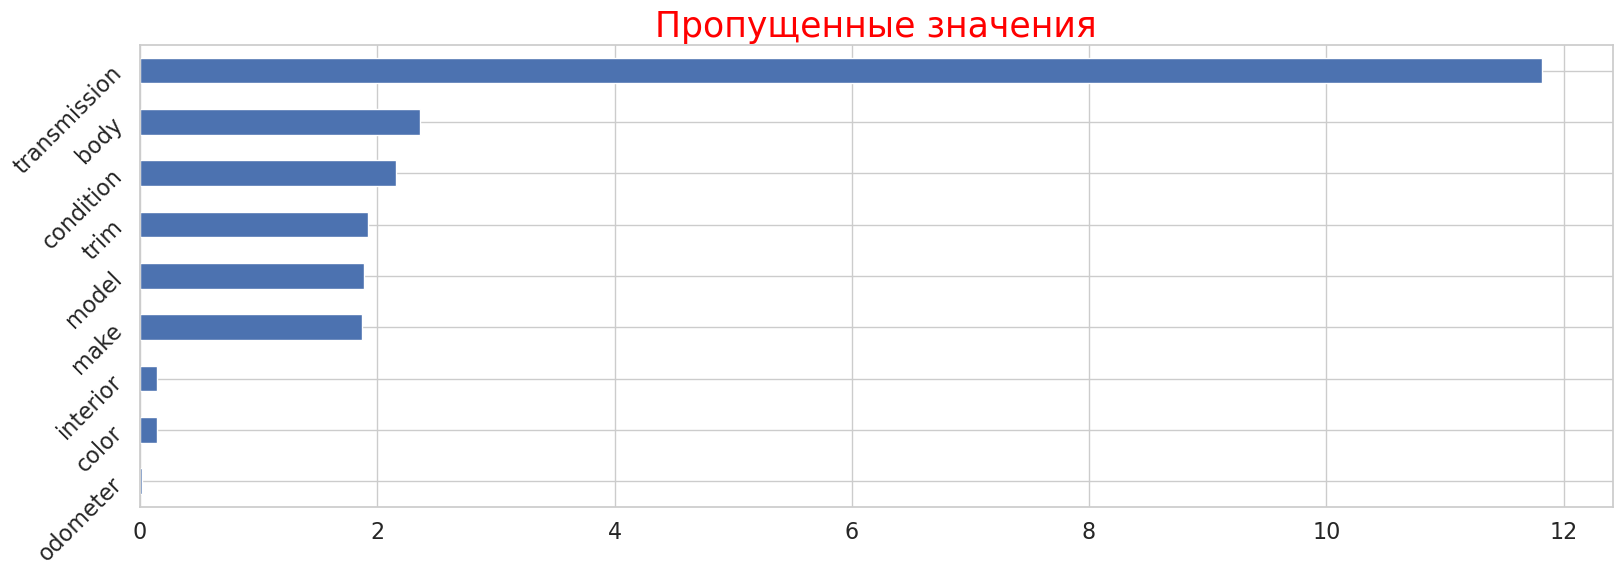

In [77]:
#  заметим, что в тесте пропорции пропусков те же, что и в трейне
isnull(df_test)

In [78]:
# количественно опишем пропуски во всех столбцах
df_train.isna().sum().sort_values(ascending = False).to_frame() 

,0
transmission,51461
body,10393
condition,9405
trim,8337
model,8123
make,8043
color,586
interior,586
odometer,69
year,0


In [79]:
df_test.isna().sum().sort_values(ascending = False).to_frame() 

,0
transmission,13011
body,2594
condition,2379
trim,2114
model,2079
make,2061
color,158
interior,158
odometer,19
year,0


**Пропуски содержатся в обоих выборках в равных пропорциях. По условию, число строк в тесте изменять нельзя, поэтому принято решение не удалять данные с пропусками, а заполнять наиболее подходящими методами.**

# ***Заполнение пропусков***
***Библиотека Vininfo позволит нам получить недостающую информацию о марке проданного авто.*** Воспользуемся этим замечательным инструментом для заполнения пропусков и в дальнейшем для генерации новых признаков. Можно предположить, что значительная часть пропусков связана с особенностями заполнения карточек объявлений (вероятно, достаточно часто человек может просто пропускать при заполнении указания одновременно полей "цвет" и "интерьер") Выявить явные закономерности для понятного заполнения пропусков, пользуясь только данными самого датасета не представляется возможным. Поэтому заменим пропуски значением "неизвестно".

In [80]:
# посмотрим на возможности вининфо
from vininfo import Vin
vin = Vin('kl1td66e49b645492')

# получим страну производителя
print(vin.country)  

# наименование производителя
print(vin.manufacturer) 

# регион производства
print(vin.region)

# информация о производителе автомобиля
print(vin.wmi) 

# здесь зашифрованы техические данные авто:тип кузова автомобиля,двигатель, модель, серия автомобиля,максимальная масса, тип шасси,
# тип трансмиссии, тип тормозной системы
print(vin.vds)

#серийный номер автомобиля (для МО бесполезен)
print(vin.vis)


South Korea
Chevrolet
Asia
KL1
TD66E4
9B645492


In [81]:
# создадим функцию получения из vin марки автомобиля
def get_manuf(m):
    return Vin(m).manufacturer

In [82]:
# создадим функцию запоняющую пропуски 
def no_passes (df):
    df['make'] = df['vin'].apply(get_manuf) 
    df['model'] = df['model'].fillna('unknown')
    df['color'] = df['color'].fillna('unknown')
    df['trim'] = df['trim'].fillna('unknown')
    df['body'] = df['body'].fillna('unknown')
    df['interior'] = df['interior'].fillna('unknown')
    df['condition'] = df['condition'].fillna(df.groupby(['year'])['condition'].transform(lambda x: x.mode()[0]))
    df['odometer'] = df['odometer'].fillna(df_train.groupby(['year','condition'])['odometer'].transform(lambda x: x.mode()[0]))
    df['transmission'] = df['transmission'].fillna(df_train.groupby(['make'])['transmission'].transform(lambda x: x.mode()[0]))
    return df

In [83]:
# применим функцию заполняющую пропуски к трейн выборке
no_passes(df_train)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,Hummer,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440231,2013,Kia,Optima,EX Hybrid,Sedan,automatic,knagm4ad4d5057805,ca,4.5,20434.0,white,beige,"kia motors america, inc",16000,Tue Jan 20 2015 04:30:00 GMT-0800 (PST)
440232,2014,Mini,Cooper Countryman,S ALL4,Wagon,automatic,wmwzc5c55ewp36517,wi,2.9,14675.0,white,black,bmw mini financial services,24250,Wed Feb 11 2015 02:00:00 GMT-0800 (PST)
440233,2008,BMW,6 Series,650i,Coupe,automatic,wbaea53588cv90110,ca,3.7,102552.0,gray,black,studio city auto group,16750,Tue Mar 03 2015 04:30:00 GMT-0800 (PST)
440234,2014,Ram,2500,SLT,Crew Cab,automatic,3c6ur5dl2eg243568,tx,3.0,29367.0,white,gray,express car & truck rental,33000,Wed Jan 14 2015 02:05:00 GMT-0800 (PST)


пропусков не осталось :)


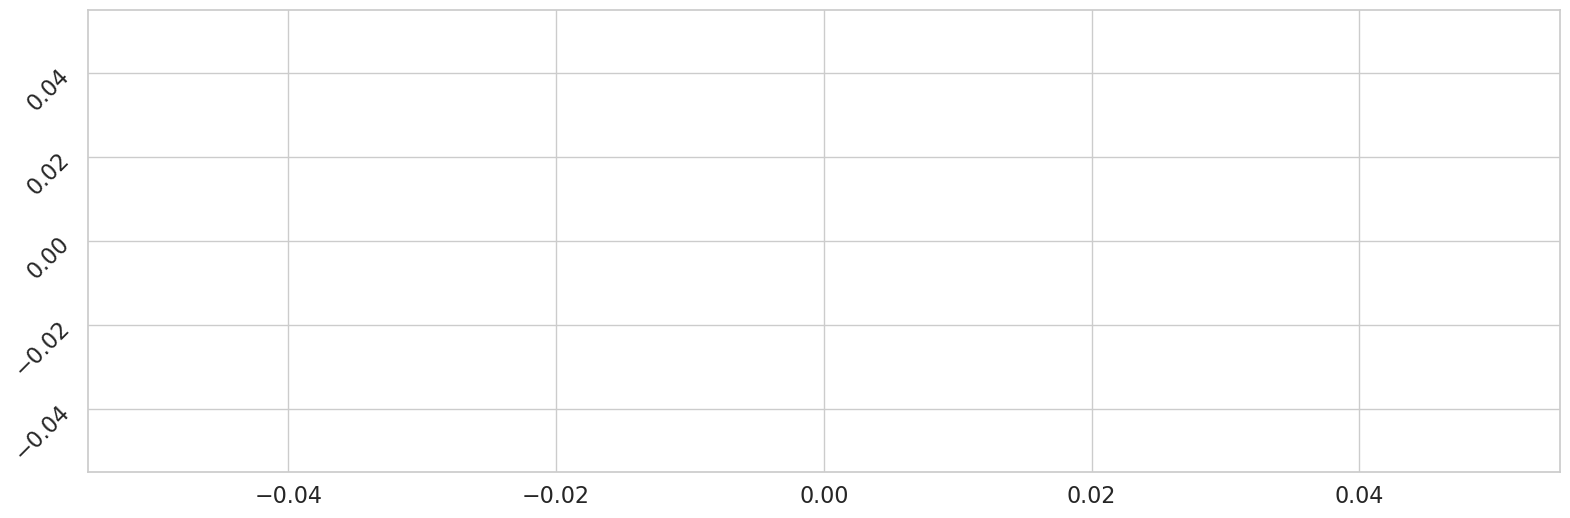

In [84]:
isnull(df_train)

In [85]:
# применим функцию заполняющую пропуски к тест выборке
no_passes(df_test)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC Truck,Savana Cargo,2500,Van,automatic,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110053,2011,Jeep,Wrangler,Sport,SUV,automatic,1j4aa2d17bl584330,ca,3.8,66085.0,orange,black,dtg operations inc,Thu Jan 15 2015 03:30:00 GMT-0800 (PST)
110054,2014,Lexus,IS 250,Base,sedan,automatic,jthbf1d23e5007526,fl,4.8,17588.0,gray,black,lexus financial services,Mon Jun 15 2015 11:00:00 GMT-0700 (PDT)
110055,2004,Nissan,Maxima,3.5 SL,Sedan,automatic,1n4ba41e54c831950,va,2.9,124036.0,silver,gray,shirlie slack mitsubishi,Thu Feb 05 2015 01:35:00 GMT-0800 (PST)
110056,2013,Nissan,370Z,Base,coupe,manual,jn1az4eh3dm382431,tx,2.2,27169.0,—,black,nissan motor acceptance corporation,Wed Jun 17 2015 03:30:00 GMT-0700 (PDT)


пропусков не осталось :)


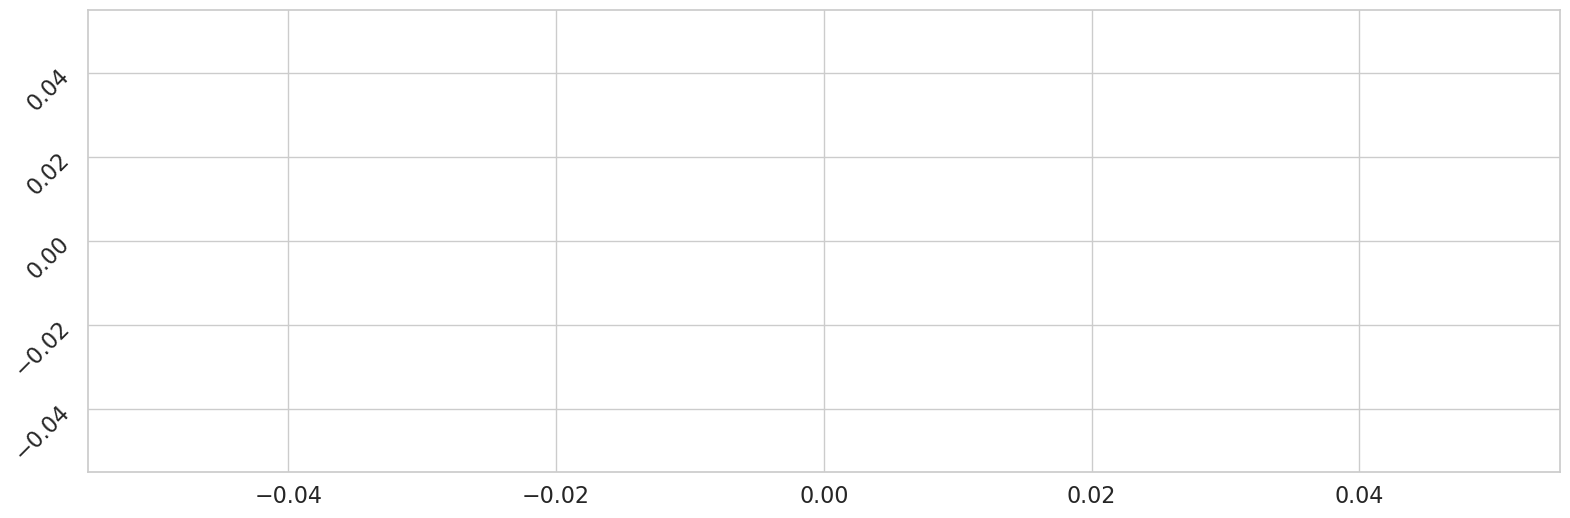

In [86]:
isnull(df_test)

In [87]:
# проверим работу функции
print(df_test.isna().sum().sum())
print(df_test.isna().sum().sum())

0
0


# ***Поиск и обработка дубликатов***

In [88]:
# проверим наличие явных дубикатов в трейн и тест выборках 

print('Количество явных дубликатов в train выборке:',df_test.duplicated().sum())
print('Количество неявных дубликатов в test выборке:',df_train.duplicated().sum())

Количество явных дубликатов в train выборке: 0
Количество неявных дубликатов в test выборке: 0


## ***Обработка неявных дубликатов***

In [89]:
# посмотрим наличие неявных дубикатов в столбце "make" в трейн выборке и посчитаем количество уникальны значений

print(df_train['make'].nunique())
print(df_train['make'].unique())

81
['Ford' 'Nissan' 'Hummer' 'Lincoln' 'Pontiac' 'Genesis' 'Toyota' 'Buick'
 'Chevrolet' 'Chevrolet Canada' 'Honda' 'Acura' 'Cadillac' 'GMC' 'Saab'
 'Chrysler' 'Mercedes-Benz' 'Chevrolet USA' 'Volkswagen' 'Mazda' 'BMW'
 'Auto Alliance International' 'Hyundai' 'Kia' 'Jaguar' 'Subaru'
 'Chrysler Canada' 'DaimlerChrysler AG/Daimler AG' 'Dodge' 'Lexus' 'Jeep'
 'Scion' 'Chevrolet Mexico' 'Fiat' 'Suzuki' 'Lexus Canada' 'Land Rover'
 'Dodge Canada' 'Volvo Cars' 'Audi' 'NUMMI' 'CAMI' 'BMW M' 'Infiniti'
 'Mini' 'Isuzu' 'GMC Truck' 'Mitsubishi' 'Smart' 'General Motors'
 'Dodge Mexico' 'Porsche car' 'Ford Otosan' 'Saturn' 'Ram' 'Honda Mexico'
 'Oldsmobile' 'Toyota Mexico' 'Mercury' 'Bentley' 'Mitsubishi Thailand'
 'Mercury Mexico' 'Porsche SUV' 'Daimler AG (Sprinter)' 'Fisker'
 'Suzuki Canada' 'Maserati' 'Quattro' 'Mercedes-Benz (Sprinter)' 'Tesla'
 'AM' 'Rolls Royce' 'Ferrari' 'Plymouth' 'Lamborghini' 'UnsupportedBrand'
 'Aston Martin Lagonda Limited' 'Volkswagen Commercial Vehicles'
 'Mazda Mex

In [90]:
# заменим неявные дубликаты и уменьшим таким образом количество уникальных значений

df_train['make'] = df_train['make'].replace(
                                            {'Chevrolet Canada':'Chevrolet',
                                             'Chevrolet USA':'Chevrolet',
                                             'BMW M':'BMW',
                                             'Chrysler Canada':'Chrysler',
                                             'Suzuki Canada':'Suzuki',
                                             'Dodge Mexico':'Dodge',
                                             'Porsche car':'Porsche ',
                                             'Porsche SUV':'Porsche ',
                                             'Mercedes-Benz (Sprinter)':'Mercedes-Benz',
                                             'AM':'Aston Martin',
                                             'Aston Martin Lagonda Limited':'Aston Martin',
                                             'Volkswagen Commercial Vehicles':'Volkswagen',
                                             'Mazda Mexico':'Mazda',
                                             'Chevrolet Australia':'Chevrolet ',
                                             'Mitsubishi Thailand':'Mitsubishi ',
                                             'GMC Truck':'GMC',
                                             'Lexus Canada':'Lexus',
                                             'Toyota Mexico':'Toyota',
                                             'Plymouth Mexico':'Plymouth'})
    
df_train['make'].nunique()

66

In [91]:
# посмотрим наличие неявных дубикатов в столбце "make"тест выборке и посчитаем количество уникальных значений

print(df_test['make'].nunique())
display(df_test['make'].unique())

80


array(['Cadillac', 'GMC Truck', 'Nissan', 'Chevrolet', 'Volkswagen',
       'Hyundai', 'Ford', 'Chevrolet Mexico', 'Subaru', 'Kia', 'BMW',
       'Chevrolet USA', 'Genesis', 'Chevrolet Canada', 'Mitsubishi',
       'Dodge', 'Oldsmobile', 'Volvo Cars', 'Pontiac', 'Acura', 'Honda',
       'Toyota', 'GMC', 'Audi', 'Lincoln', 'Ford Otosan', 'Infiniti',
       'Jeep', 'Chrysler Canada', 'DaimlerChrysler AG/Daimler AG',
       'Chrysler', 'Ram', 'Scion', 'Dodge Canada', 'Dodge Mexico',
       'Mercury', 'Lexus Canada', 'Lexus', 'Saturn', 'Mazda',
       'Mercedes-Benz', 'Porsche car', 'NUMMI',
       'Auto Alliance International', 'Mini', 'Smart', 'Land Rover',
       'Buick', 'Toyota Mexico', 'BMW M', 'Hummer', 'Jaguar', 'Fiat',
       'Mitsubishi Thailand', 'CAMI', 'Porsche SUV', 'Saab',
       'General Motors', 'Mercury Mexico', 'Suzuki', 'Suzuki Canada',
       'Quattro', 'Bentley', 'Honda Mexico', 'Mercedes-Benz (Sprinter)',
       'Isuzu', 'Aston Martin Lagonda Limited', 'Daimler AG (S

In [92]:
# заменим неявные дубликаты и уменьшим таким образом количество уникальных значений

df_test['make'] = df_test['make'].replace(
                                         {'Chevrolet Canada':'Chevrolet',
                                             'Chevrolet USA':'Chevrolet',
                                             'BMW M':'BMW',
                                             'Chrysler Canada':'Chrysler',
                                             'Suzuki Canada':'Suzuki',
                                             'Dodge Mexico':'Dodge',
                                             'Porsche car':'Porsche ',
                                             'Porsche SUV':'Porsche ',
                                             'Mercedes-Benz (Sprinter)':'Mercedes-Benz',
                                             'AM':'Aston Martin',
                                             'Aston Martin Lagonda Limited':'Aston Martin',
                                             'Volkswagen Commercial Vehicles':'Volkswagen',
                                             'Mazda Mexico':'Mazda',
                                             'Chevrolet Australia':'Chevrolet ',
                                             'Mitsubishi Thailand':'Mitsubishi ',
                                             'GMC Truck':'GMC',
                                             'Lexus Canada':'Lexus',
                                             'Toyota Mexico':'Toyota',
                                             'Plymouth Mexico':'Plymouth'})

print(df_test['make'].nunique())

66


In [93]:
# посмотрим количество уникальны значений в в столбце "model" в трейн выборке
print(df_train['model'].nunique())

960


In [94]:
# приведем написание к виду с заглавной буквы
df_train['model'] = df_train['model'].str.capitalize()
print(df_train['model'].nunique())

840


In [95]:
# посмотрим количество уникальны значений в в столбце "model" в тестовой выборке
print(df_train['model'].nunique())
df_test['model'] = df_test['model'].str.capitalize()
print(df_test['model'].nunique())

840
747


In [96]:
# посмотрим количество уникальных значений в в столбце "body"
df_train['body'] = df_train['body'].str.lower()
print(df_train['body'].nunique())
print(df_train['body'].unique())

46
['suv' 'sedan' 'unknown' 'wagon' 'minivan' 'extended cab' 'regular cab'
 'coupe' 'supercrew' 'convertible' 'crew cab' 'supercab' 'hatchback'
 'g coupe' 'g convertible' 'access cab' 'g sedan' 'e-series van'
 'quad cab' 'tsx sport wagon' 'van' 'cts coupe' 'koup' 'king cab'
 'double cab' 'elantra coupe' 'crewmax cab' 'genesis coupe' 'g37 coupe'
 'club cab' 'beetle convertible' 'mega cab' 'regular-cab' 'xtracab'
 'q60 coupe' 'promaster cargo van' 'cts-v coupe' 'cts wagon' 'cab plus 4'
 'g37 convertible' 'transit van' 'q60 convertible' 'cab plus' 'ram van'
 'granturismo convertible' 'cts-v wagon']


In [97]:
# посмотрим количество уникальных значений в в столбце "body"
print(df_test['body'].nunique())

78


In [98]:
# приведем написание к строчному регистру
df_test['body'] = df_test['body'].str.lower()
print(df_test['body'].nunique())

43


In [99]:
print(df_train['trim'].nunique())
print(df_test['trim'].nunique())

1923
1497


In [100]:
# приведем написание к строчному регистру
df_train['trim'] = df_train['trim'].str.lower()
print(df_train['trim'].nunique())

1851


In [101]:
# приведем написание к строчному регистру
df_test['trim'] = df_test['trim'].str.lower()
print(df_test['trim'].nunique())

1458


# ***Исследовательский анализ***

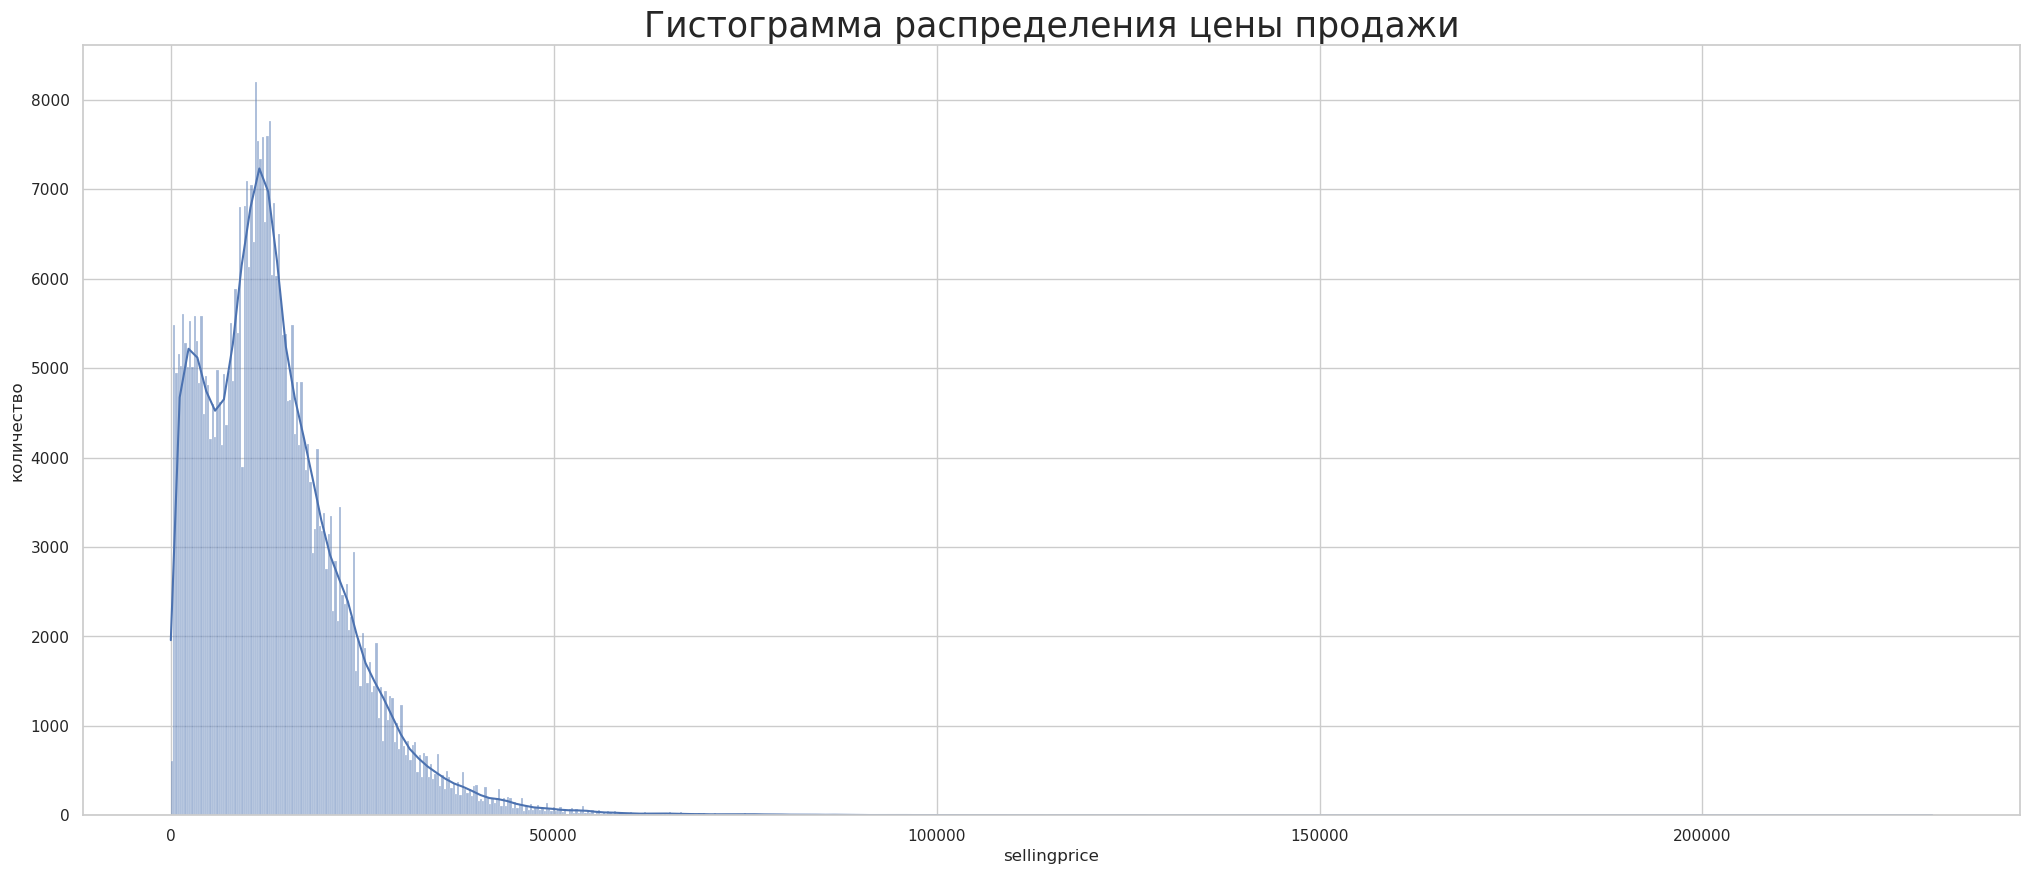

In [102]:
#построим гистограммы столбца с целевым признаком
sns.set(rc={"figure.figsize": (25, 10)})
sns.set_style('whitegrid')
ahf = sns.histplot(data=df_train, x='sellingprice', kde=True)
ahf.set_ylabel('количество')
ahf.set_title('Гистограмма распределения цены продажи', fontsize=25);

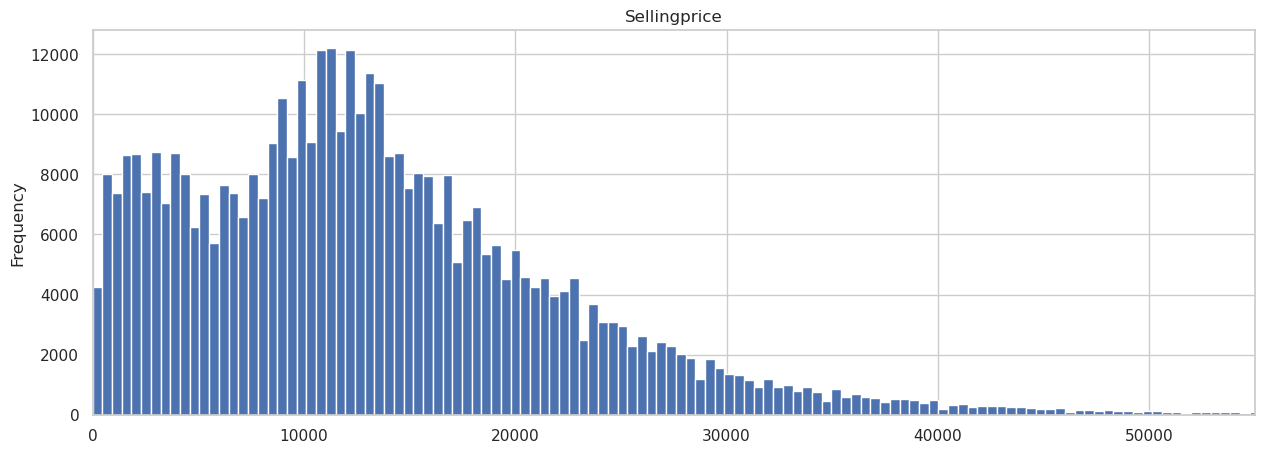

In [103]:

df_train['sellingprice'].plot (kind='hist', xlim=(0,55000), title='Sellingprice',  bins=500, figsize=(15,5));

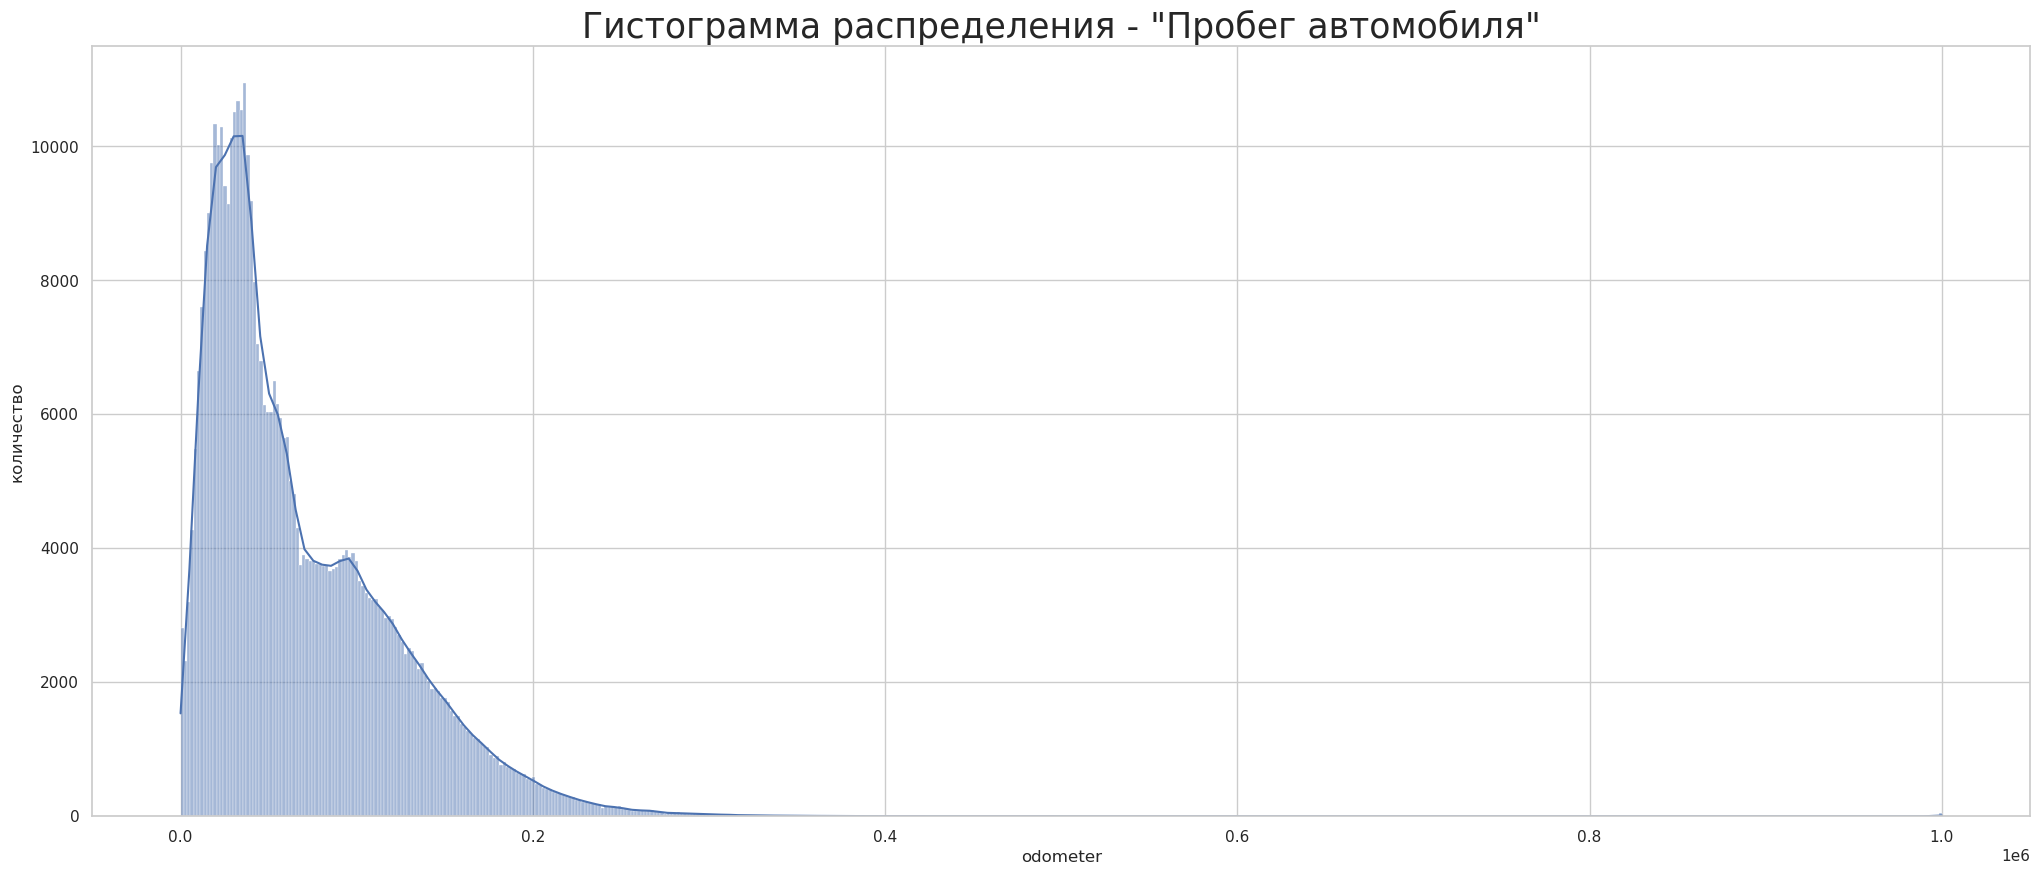

In [104]:
# построим гистограммы столбца с показаниями одометра
sns.set(rc={"figure.figsize": (25, 10)})
sns.set_style('whitegrid')
ahf = sns.histplot(data=df_train, x='odometer', kde=True)
ahf.set_ylabel('количество')
ahf.set_title('Гистограмма распределения - "Пробег автомобиля"', fontsize=25);

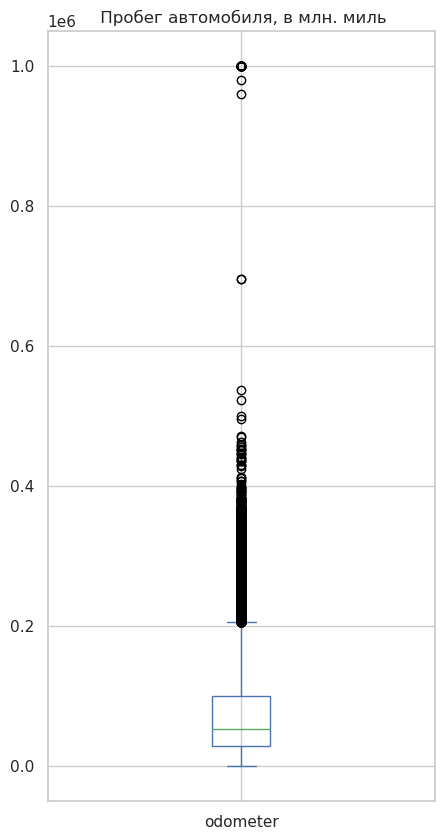

In [105]:
# построим  боксплот с пробегом автомобилей
df_train['odometer'].plot(kind='box', figsize=(5, 10))
plt.title(' Пробег автомобиля, в млн. миль');

In [106]:
# создадим функцию визуализации 10 самых популярных значений
def barplot(column, title):
    fig, ax = plt.subplots(figsize=(15, 5))
    pivot = pd.DataFrame(df_train.pivot_table(index=column, aggfunc="size").sort_values(ascending=False)).head(10)
    sns.barplot(data=pivot, x=0, y=pivot.index)
    ax.set_title(title)
    plt.xlabel('Количество')
    plt.show()

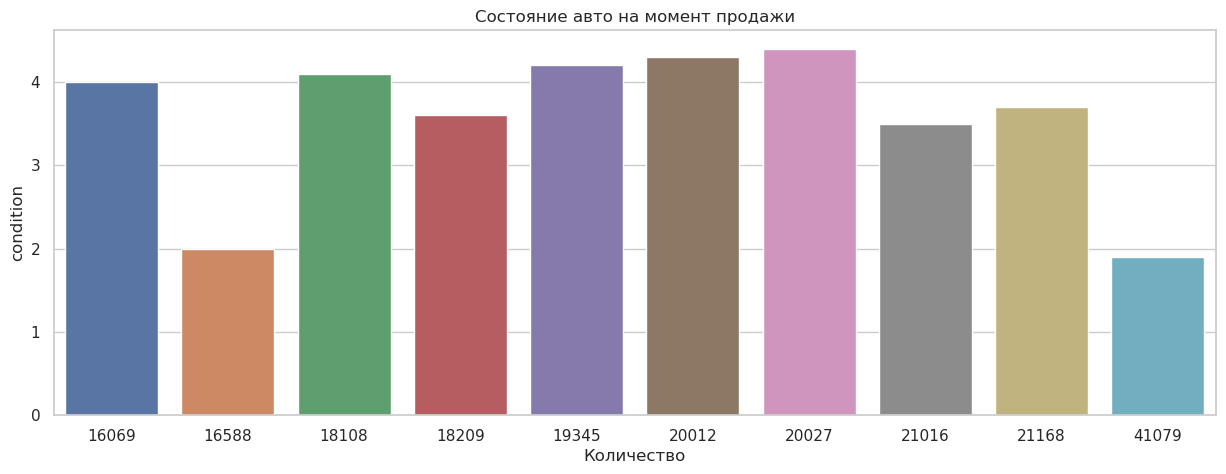

In [107]:
# посмотрим в каком состоянии чаще всего продают автомобили
barplot('condition', 'Состояние авто на момент продажи')

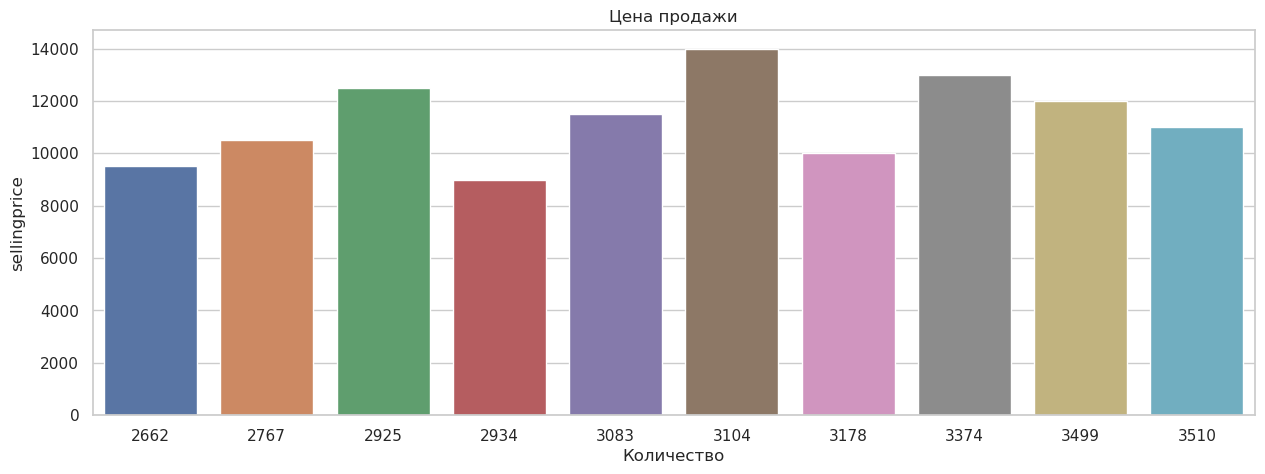

In [108]:
# посмотрим популярные показатели стоимости авто
barplot('sellingprice', 'Цена продажи')

In [109]:
# создадим функцию зависимости цены от признака
def price_plot(feature, title):
    mean_price = df_train[[feature, 'sellingprice']].groupby(feature, as_index=False).mean().astype('int')
    plt.figure(figsize=(12,6))
    plt.grid(axis = 'both')
    
    sns.lineplot(x=feature, y='sellingprice', data=mean_price)
    plt.xlabel(feature, size=12)
    plt.ylabel('Средняя цена в $', size=12)
    plt.title(title, size=15, y=1.02)
    plt.show()

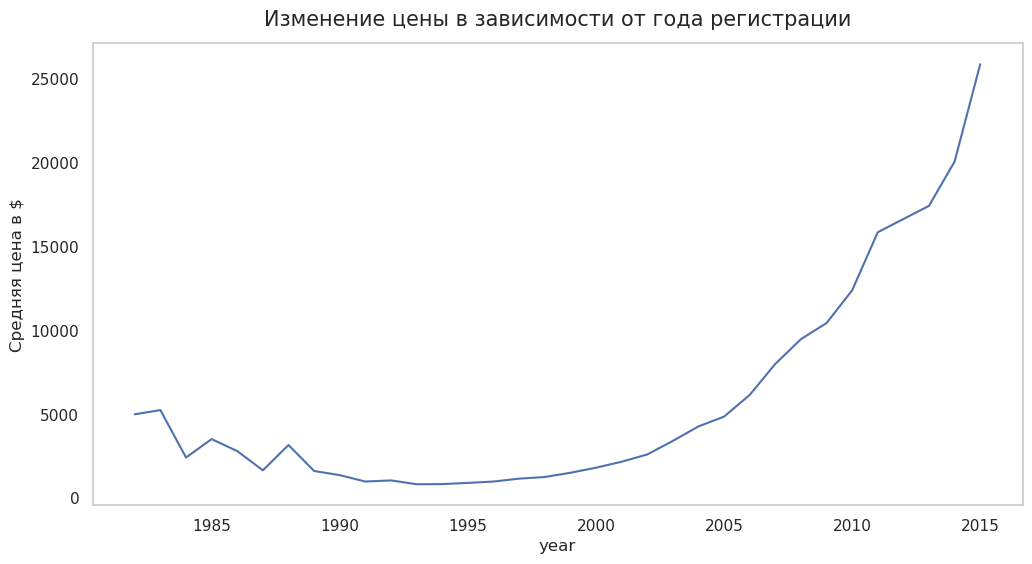

In [110]:
# посмотрим зависимость цены от года регистрации
price_plot('year', 'Изменение цены в зависимости от года регистрации')

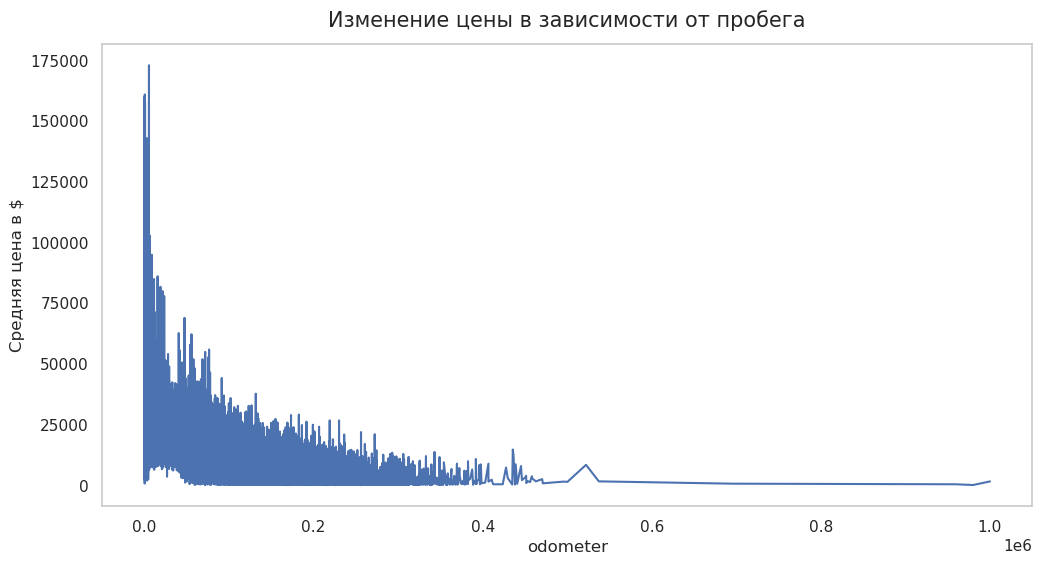

In [111]:
# посмотрим зависимость цены от пробега
price_plot('odometer', 'Изменение цены в зависимости от пробега')

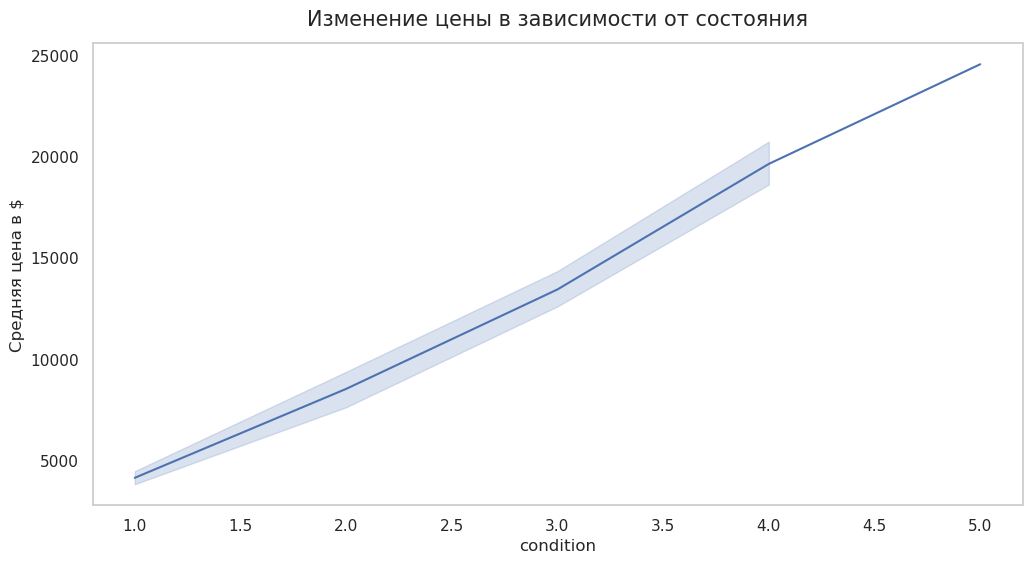

In [112]:
# посмотрим зависимость цены от состояния автомобиля
price_plot('condition', 'Изменение цены в зависимости от состояния')

## ***Вводы по исследовательскому анализу***
Несомненно в столбцах пробег и цена присутствуют выбросы, они могут "шокировать" модели, но так как речь идёт о рынке б/у автомобилей, примем их как вариант нормы. Ведь в жизни также встречается и пробег в миллион миль и цена 400000 долларов.
Заметим что высока обратная корреляция между ценой и пробегом, а также прямая - между состоянием и ценой.


# ***Генерация признаков***

In [113]:
#переведем столбец "дата продажи" в формат datetime
df_train['saledate'] = pd.to_datetime(df_train['saledate'], utc=True)
df_test['saledate'] = pd.to_datetime(df_test['saledate'], utc=True)

In [114]:
# через функцию создадим несколько признаков на основе столба с датой продажи: месяц, год, день, недели и возраст авто

def time_features (df):
    df['month'] = pd.DatetimeIndex(df['saledate']).month
    df['year_sale'] = df['saledate'].dt.year
    df['dayofweek'] = df['saledate'].dt.weekday
    df['car_age'] = df['year_sale']- df['year']
 
    return df

In [115]:
time_features(df_train).sample()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,month,year_sale,dayofweek,car_age
17886,2013,Chevrolet,Equinox,ltz,suv,automatic,2gnflgek6d6362357,ca,2.0,37330.0,white,black,hertz/tra,10500,2015-01-19 20:00:00+00:00,1,2015,0,2


In [116]:
time_features(df_test).sample()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,month,year_sale,dayofweek,car_age
56803,2009,Honda,Civic,hybrid,sedan,automatic,jhmfa36209s005782,ca,1.9,81408.0,gray,beige,arrowhead auto group inc,2015-01-21 20:00:00+00:00,1,2015,2,6


In [117]:
# с помощью винининфо экстрагируем новые признаки. 1) страну производителя
def get_country(c):
    return Vin(c).country

In [118]:
df_train['country'] = df_train['vin'].apply(get_country)
df_test['country'] = df_test['vin'].apply(get_country)

In [119]:
#  2) регион производства
def get_region(r):
    return Vin(r).region

In [120]:
df_train['region'] = df_train['vin'].apply(get_region)
df_test['region'] = df_test['vin'].apply(get_region)

In [121]:
# 3) информация о производителе автомобиля
def get_wmi(wmi):
    return Vin(wmi).wmi 

In [122]:
df_train['wmi'] = df_train['vin'].apply(get_wmi)
df_test['wmi'] = df_test['vin'].apply(get_wmi)

In [123]:
# 4) техические данные авто: тип кузова ,двигатель, модель, серия ,максимальная масса, тип шасси, тип трансмиссии, тип тормозной системы
def get_vds(v):
    return Vin(v).vds 

In [124]:
df_train['vds'] = df_train['vin'].apply(get_vds)
df_test['vds'] = df_test['vin'].apply(get_vds)

In [125]:
print(df_train.corr()) 

                  year  condition  odometer  sellingprice     month  \
year          1.000000   0.568258 -0.773886      0.586847 -0.049142   
condition     0.568258   1.000000 -0.550572      0.546649 -0.083600   
odometer     -0.773886  -0.550572  1.000000     -0.582733  0.042611   
sellingprice  0.586847   0.546649 -0.582733      1.000000 -0.031175   
month        -0.049142  -0.083600  0.042611     -0.031175  1.000000   
year_sale     0.116470   0.115596 -0.087505      0.077356 -0.824648   
dayofweek    -0.048322  -0.027066  0.027197     -0.001741  0.105279   
car_age      -0.997221  -0.562973  0.771933     -0.584540 -0.012423   

              year_sale  dayofweek   car_age  
year           0.116470  -0.048322 -0.997221  
condition      0.115596  -0.027066 -0.562973  
odometer      -0.087505   0.027197  0.771933  
sellingprice   0.077356  -0.001741 -0.584540  
month         -0.824648   0.105279 -0.012423  
year_sale      1.000000  -0.147524 -0.042153  
dayofweek     -0.147524   1.000

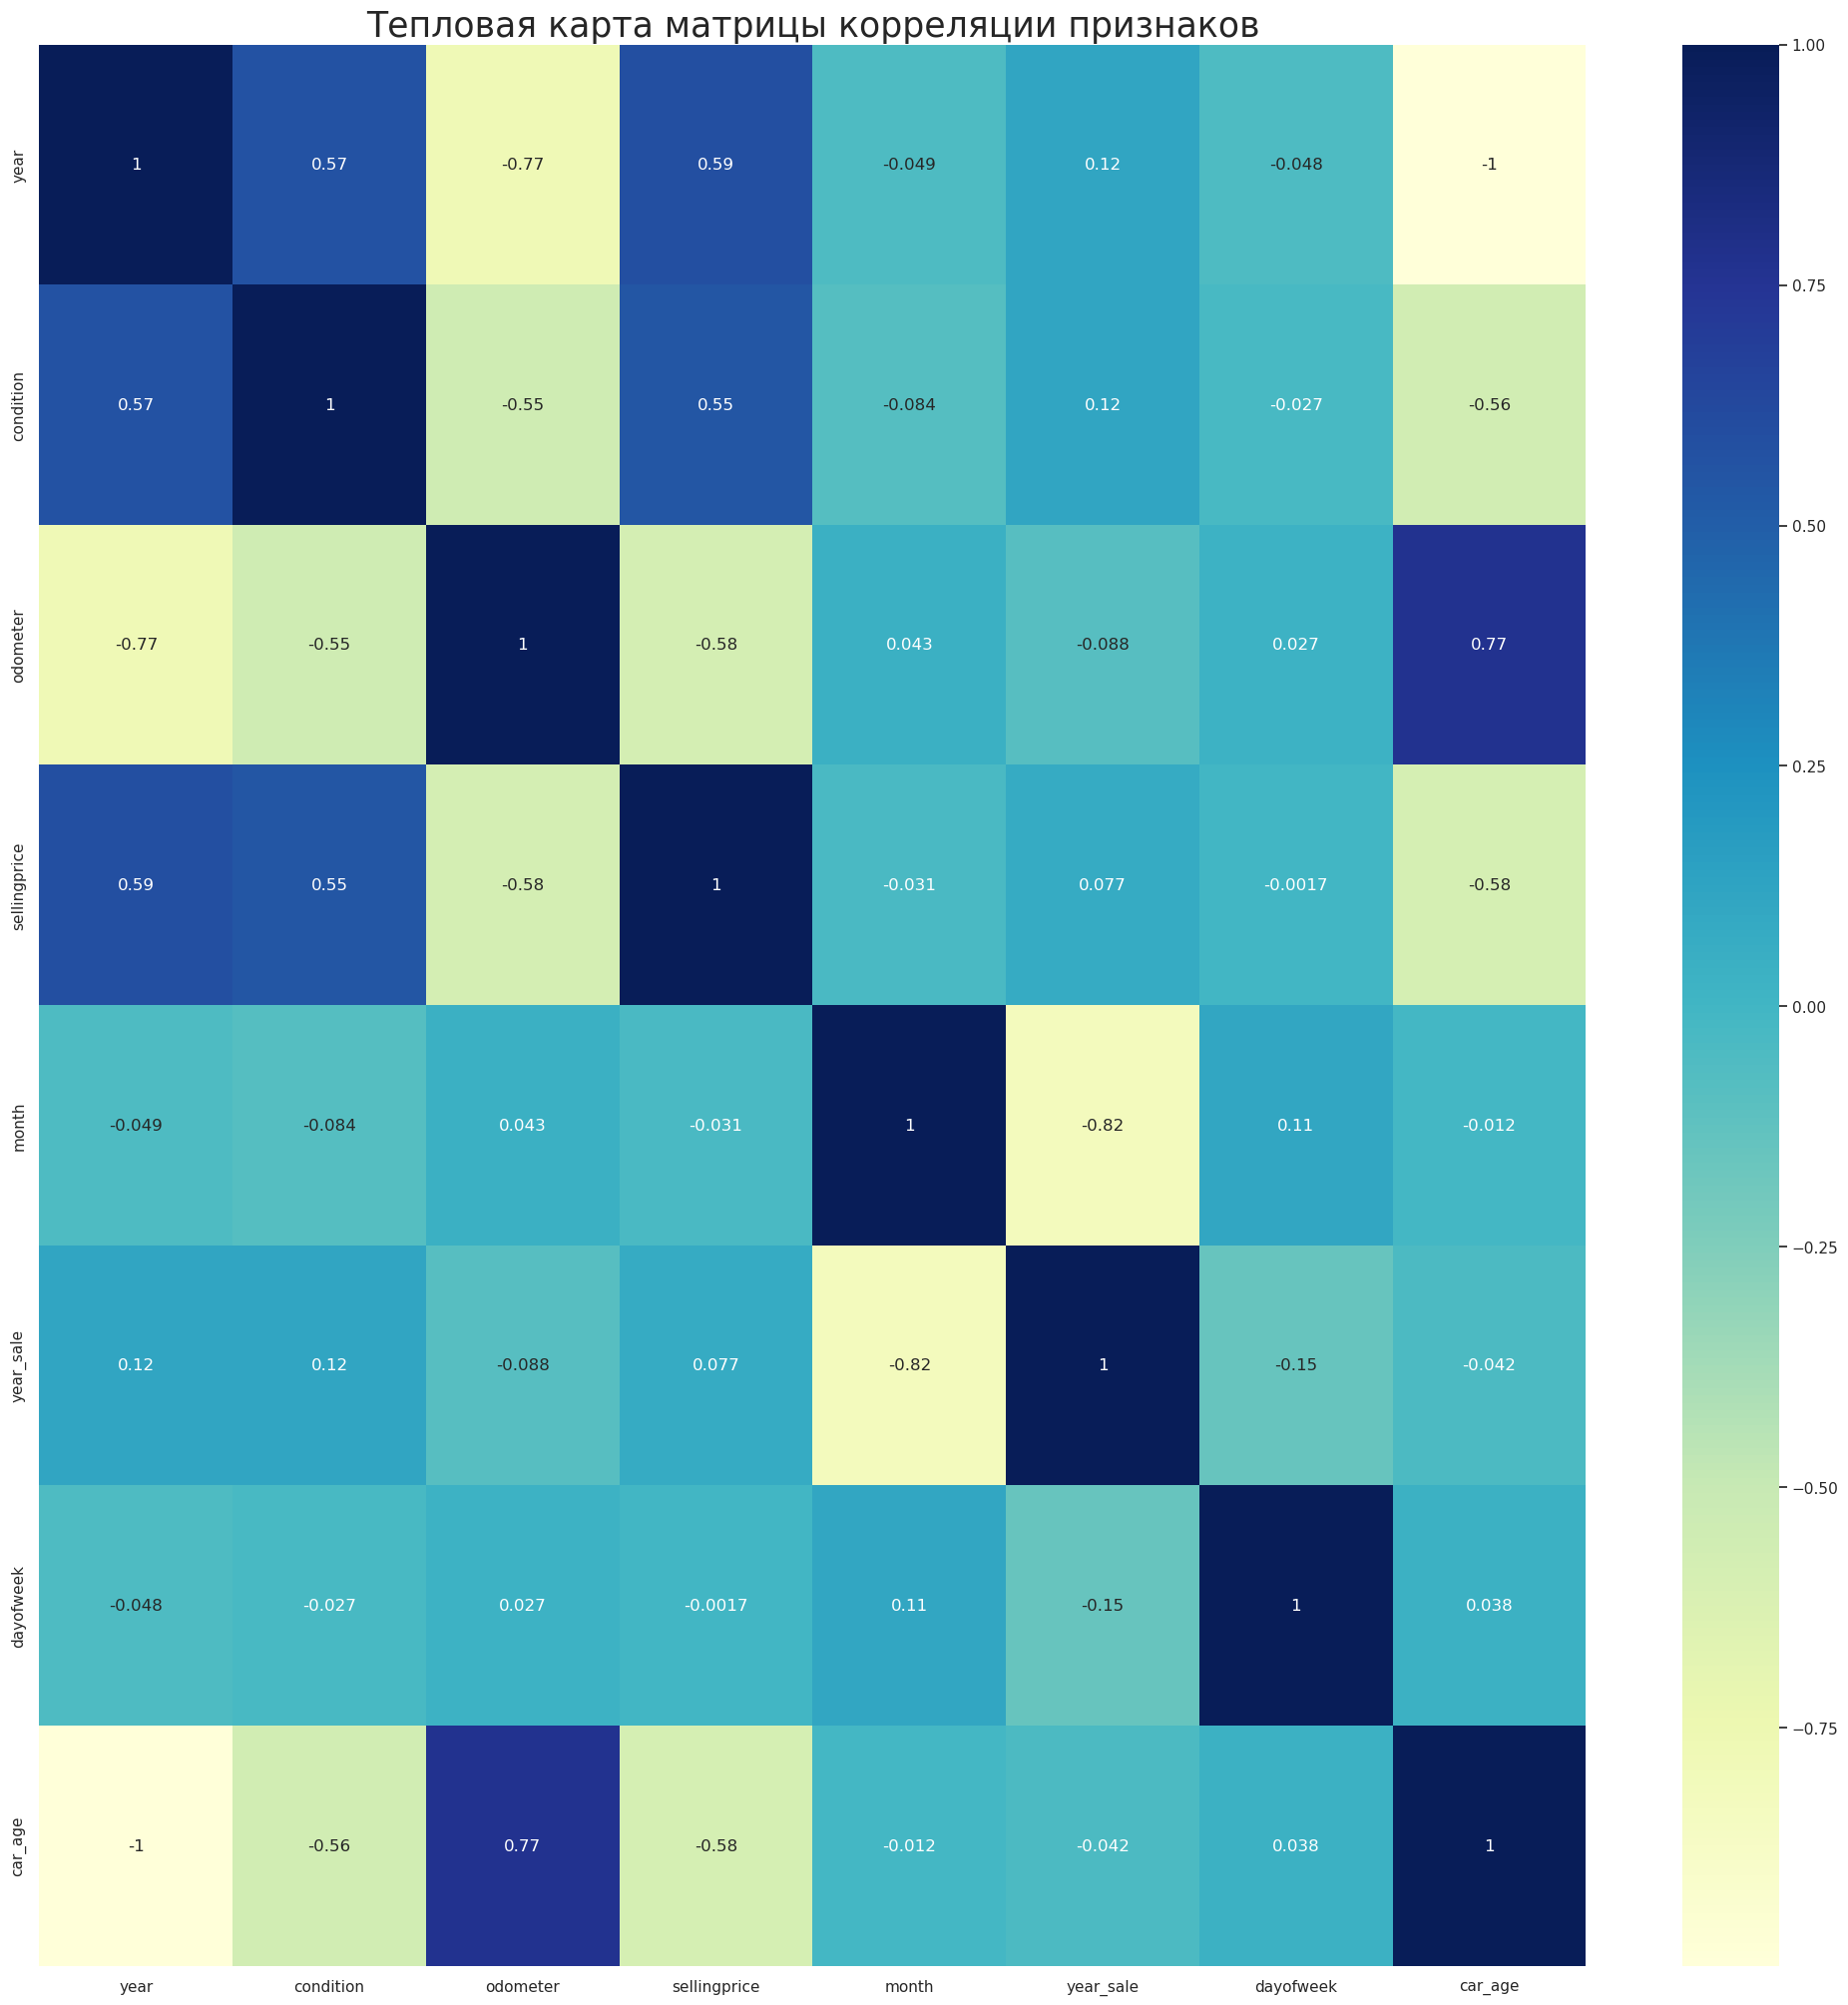

In [126]:
# построим тепловую карту корреляции признаков
corr_matrix = df_train.corr()
fig, ax = plt.subplots(figsize=(25, 25))
plt.title("Тепловая карта матрицы корреляции признаков",fontsize=25)
#create seaborn heatmap
sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True);

In [127]:
# посмотрим на пары с высокой корреляцией
corr_pairs = corr_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
strong_pairs = sorted_pairs[abs(sorted_pairs) > 0.79]
display(strong_pairs)

car_age       year           -0.997221
year          car_age        -0.997221
year_sale     month          -0.824648
month         year_sale      -0.824648
year          year            1.000000
year_sale     year_sale       1.000000
month         month           1.000000
sellingprice  sellingprice    1.000000
odometer      odometer        1.000000
condition     condition       1.000000
dayofweek     dayofweek       1.000000
car_age       car_age         1.000000
dtype: float64

**Прослеживается сильная корреляция столбца возраст авто с годом регистрации, а также между годом и месяцем продажи, исключим из признаков по одному из пары.**

In [128]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   year          440236 non-null  int64              
 1   make          440236 non-null  object             
 2   model         440236 non-null  object             
 3   trim          440236 non-null  object             
 4   body          440236 non-null  object             
 5   transmission  440236 non-null  object             
 6   vin           440236 non-null  object             
 7   state         440236 non-null  object             
 8   condition     440236 non-null  float64            
 9   odometer      440236 non-null  float64            
 10  color         440236 non-null  object             
 11  interior      440236 non-null  object             
 12  seller        440236 non-null  object             
 13  sellingprice  440236 non-null  int64        

In [129]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   year          110058 non-null  int64              
 1   make          110058 non-null  object             
 2   model         110058 non-null  object             
 3   trim          110058 non-null  object             
 4   body          110058 non-null  object             
 5   transmission  110058 non-null  object             
 6   vin           110058 non-null  object             
 7   state         110058 non-null  object             
 8   condition     110058 non-null  float64            
 9   odometer      110058 non-null  float64            
 10  color         110058 non-null  object             
 11  interior      110058 non-null  object             
 12  seller        110058 non-null  object             
 13  saledate      110058 non-null  datetime64[ns

In [130]:
df_test_copy = df_test.copy()
df_test_copy.shape

(110058, 22)

In [131]:
df_test = df_test.drop(['vin','saledate','car_age', 'month'], axis=1)
df_train = df_train.drop(['vin','saledate','car_age', 'month'], axis=1)

# ***Разделение на тренировочную и валидационные выборки***   

In [132]:
features = df_train.drop(['sellingprice'], axis=1)
target = df_train['sellingprice']
features_train, features_valid, target_train, target_valid = train_test_split\
(features, target, test_size=0.25, random_state=RANDOM_STATE)

In [133]:
# проверим разбивку на выборки
display(features_train.shape) # обучающий набор 75%
display(target_train.shape)
display(features_valid.shape)# валидационный набор 25%
display(target_valid.shape)
display(df_test.shape)

(330177, 18)

(330177,)

(110059, 18)

(110059,)

(110058, 18)

In [134]:
features_train_copy = features_train.copy()
features_valid_copy = features_valid.copy()
features_test = df_test.copy()

# **Обучение моделей**


In [135]:
num_features = features_train.select_dtypes(include=['number']).columns.to_list()
print('Список цифровых признаков:', num_features)
cat_features = features_train.select_dtypes(include=['object']).columns.to_list()
print('Список категориальных признаков:', cat_features)

Список цифровых признаков: ['year', 'condition', 'odometer', 'year_sale', 'dayofweek']
Список категориальных признаков: ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller', 'country', 'region', 'wmi', 'vds']


In [138]:
# инициализируем модель линейной регрессии
model_LR = LinearRegression()

 # ***Применение Pipeline в препроцессинге***

In [139]:
col_transformer_linear = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features),
    (MinMaxScaler(), num_features),
    remainder='passthrough')

In [140]:
pipeline_linear = make_pipeline(col_transformer_linear, model_LR)
pipeline_linear

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['make', 'model', 'trim',
                                                   'body', 'transmission',
                                                   'state', 'color', 'interior',
                                                   'seller', 'country',
                                                   'region', 'wmi', 'vds']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['year', 'condition',
                                                   'odometer', 'year_sale',
                                                   'dayofweek'])])),
                ('linearregression', LinearRegression())])

In [141]:
%%time
pipeline_linear.fit(features_train, target_train)

CPU times: user 3.71 s, sys: 299 ms, total: 4.01 s
Wall time: 3.73 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['make', 'model', 'trim',
                                                   'body', 'transmission',
                                                   'state', 'color', 'interior',
                                                   'seller', 'country',
                                                   'region', 'wmi', 'vds']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['year', 'condition',
                                                   'odometer', 'year_sale',
                                                   'dayofweek'])])),
                ('linearregression', LinearRegression())])

In [142]:
%%time
pred_valid_LR = pipeline_linear.predict(features_valid)
print(mean_absolute_percentage_error(target_valid, pred_valid_LR))

0.7169567668758995
CPU times: user 1.44 s, sys: 12.9 ms, total: 1.46 s
Wall time: 1.44 s


In [143]:
%%time 
# инициализируем ансамблевую модель 'RandomForest'
model_RF = RandomForestRegressor(criterion = "squared_error", random_state=42,n_estimators = 500, n_jobs=-1)
pipeline_forest = make_pipeline(col_transformer_linear, model_RF)
pipeline_forest.fit(features_train, target_train)

CPU times: user 43min 14s, sys: 16.3 s, total: 43min 31s
Wall time: 11min 16s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['make', 'model', 'trim',
                                                   'body', 'transmission',
                                                   'state', 'color', 'interior',
                                                   'seller', 'country',
                                                   'region', 'wmi', 'vds']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['year', 'condition',
                                                   'odometer', 'year_sale',
                                                   'dayofweek'])])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=500, n_jobs=-1,
                                       random_state=42))])

In [144]:
%%time 
pred_valid_RF = pipeline_forest.predict(features_valid)
print(mean_absolute_percentage_error(target_valid, pred_valid_RF))

0.1919435592302314
CPU times: user 52.5 s, sys: 101 ms, total: 52.6 s
Wall time: 14.6 s


In [145]:
%%time
model_Cat = CatBoostRegressor(depth=10, learning_rate = 0.05, loss_function="RMSE", iterations=1000)
pipeline_catboost = make_pipeline(col_transformer_linear, model_Cat)
pipeline_catboost.fit(features_train, target_train)

0:	learn: 9428.4547181	total: 194ms	remaining: 3m 13s
1:	learn: 9134.4957286	total: 323ms	remaining: 2m 41s
2:	learn: 8856.1791795	total: 462ms	remaining: 2m 33s
3:	learn: 8597.5637179	total: 616ms	remaining: 2m 33s
4:	learn: 8343.2919792	total: 741ms	remaining: 2m 27s
5:	learn: 8114.1389067	total: 864ms	remaining: 2m 23s
6:	learn: 7889.3799265	total: 990ms	remaining: 2m 20s
7:	learn: 7688.6408702	total: 1.11s	remaining: 2m 18s
8:	learn: 7505.2448831	total: 1.23s	remaining: 2m 15s
9:	learn: 7327.5007200	total: 1.36s	remaining: 2m 14s
10:	learn: 7158.9732322	total: 1.48s	remaining: 2m 13s
11:	learn: 7001.0523551	total: 1.6s	remaining: 2m 11s
12:	learn: 6854.1413881	total: 1.73s	remaining: 2m 11s
13:	learn: 6711.2182243	total: 1.85s	remaining: 2m 10s
14:	learn: 6575.7504124	total: 1.97s	remaining: 2m 9s
15:	learn: 6456.4872604	total: 2.09s	remaining: 2m 8s
16:	learn: 6339.3445520	total: 2.21s	remaining: 2m 8s
17:	learn: 6219.0043699	total: 2.34s	remaining: 2m 7s
18:	learn: 6106.3203727	t

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['make', 'model', 'trim',
                                                   'body', 'transmission',
                                                   'state', 'color', 'interior',
                                                   'seller', 'country',
                                                   'region', 'wmi', 'vds']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['year', 'condition',
                                                   'odometer', 'year_sale',
                                                   'dayofweek'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x792b48fee0b0>)])

In [146]:
%%time 
pred_valid_cat = pipeline_catboost.predict(features_valid)
print(mean_absolute_percentage_error(target_valid, pred_valid_cat))

0.19077920116144462
CPU times: user 3.58 s, sys: 21.8 ms, total: 3.6 s
Wall time: 2.93 s


In [147]:
display(features_train_copy.shape)
display(features_valid_copy.shape)
display(features_test.shape)

(330177, 18)

(110059, 18)

(110058, 18)

In [148]:
# инициализируем  модель градиентного бустинга 'CatBoostRegressor'

# обучим  модель на тренировочной выборке без препроцессинга 

model_Cat.fit(features_train_copy, target_train, cat_features=cat_features)

0:	learn: 9384.8249691	total: 1.51s	remaining: 25m 11s
1:	learn: 9050.2441590	total: 3.15s	remaining: 26m 13s
2:	learn: 8734.6102768	total: 4.86s	remaining: 26m 53s
3:	learn: 8434.2205069	total: 6.42s	remaining: 26m 39s
4:	learn: 8161.7822088	total: 7.66s	remaining: 25m 23s
5:	learn: 7894.1509841	total: 9.09s	remaining: 25m 5s
6:	learn: 7633.9001648	total: 10.4s	remaining: 24m 34s
7:	learn: 7400.6405950	total: 11.9s	remaining: 24m 29s
8:	learn: 7168.1712133	total: 13.3s	remaining: 24m 19s
9:	learn: 6962.6475098	total: 14.6s	remaining: 24m 4s
10:	learn: 6756.7091449	total: 15.8s	remaining: 23m 44s
11:	learn: 6568.2594493	total: 17.4s	remaining: 23m 50s
12:	learn: 6380.1302340	total: 18.7s	remaining: 23m 42s
13:	learn: 6210.8541306	total: 20s	remaining: 23m 25s
14:	learn: 6054.9235755	total: 21.3s	remaining: 23m 17s
15:	learn: 5897.0589393	total: 22.5s	remaining: 23m 2s
16:	learn: 5751.8068940	total: 23.6s	remaining: 22m 46s
17:	learn: 5617.0487878	total: 25.1s	remaining: 22m 48s
18:	lea

In [149]:
%%time
# предскажем таргет на валидационной выборке
pred_valid_cat = model_Cat.predict(features_valid_copy) 

# оценим предсказания метрикой MAPE
print(mean_absolute_percentage_error(target_valid, pred_valid_cat))

0.15669226358702643
CPU times: user 9.98 s, sys: 60.9 ms, total: 10 s
Wall time: 2.91 s


In [150]:
# оценим результаты работы моделей и выберем лучшую

results = { 
    'Model' : ['LinearRegressor', 'RandomForestRegressor', 'CatboosRegressor'],
    'Train MAPE' :pd.Series([0.71, 0.19, 0.15]),
    'Time, мин': pd.Series(['1', '12', '25'])
    }
display(pd.DataFrame(results))

,Model,Train MAPE,"Time, мин"
0,LinearRegressor,0.71,1
1,RandomForestRegressor,0.19,12
2,CatboosRegressor,0.15,25


In [151]:
# предскажем таргет на тестовой выборке

pred_test_cat = model_Cat.predict(features_test) 

In [152]:
# создадим табицу vin + предсказание цены

prediction = pd.Series(pred_test_cat) 

vin_price =  pd.concat([df_test_copy['vin'],prediction],  axis=1)
vin_price.columns = ['vin', 'sellingprice']
vin_price.sample()


,vin,sellingprice
43704,jnkcp11a2yt312304,1669.381647


## **Важность признаков**

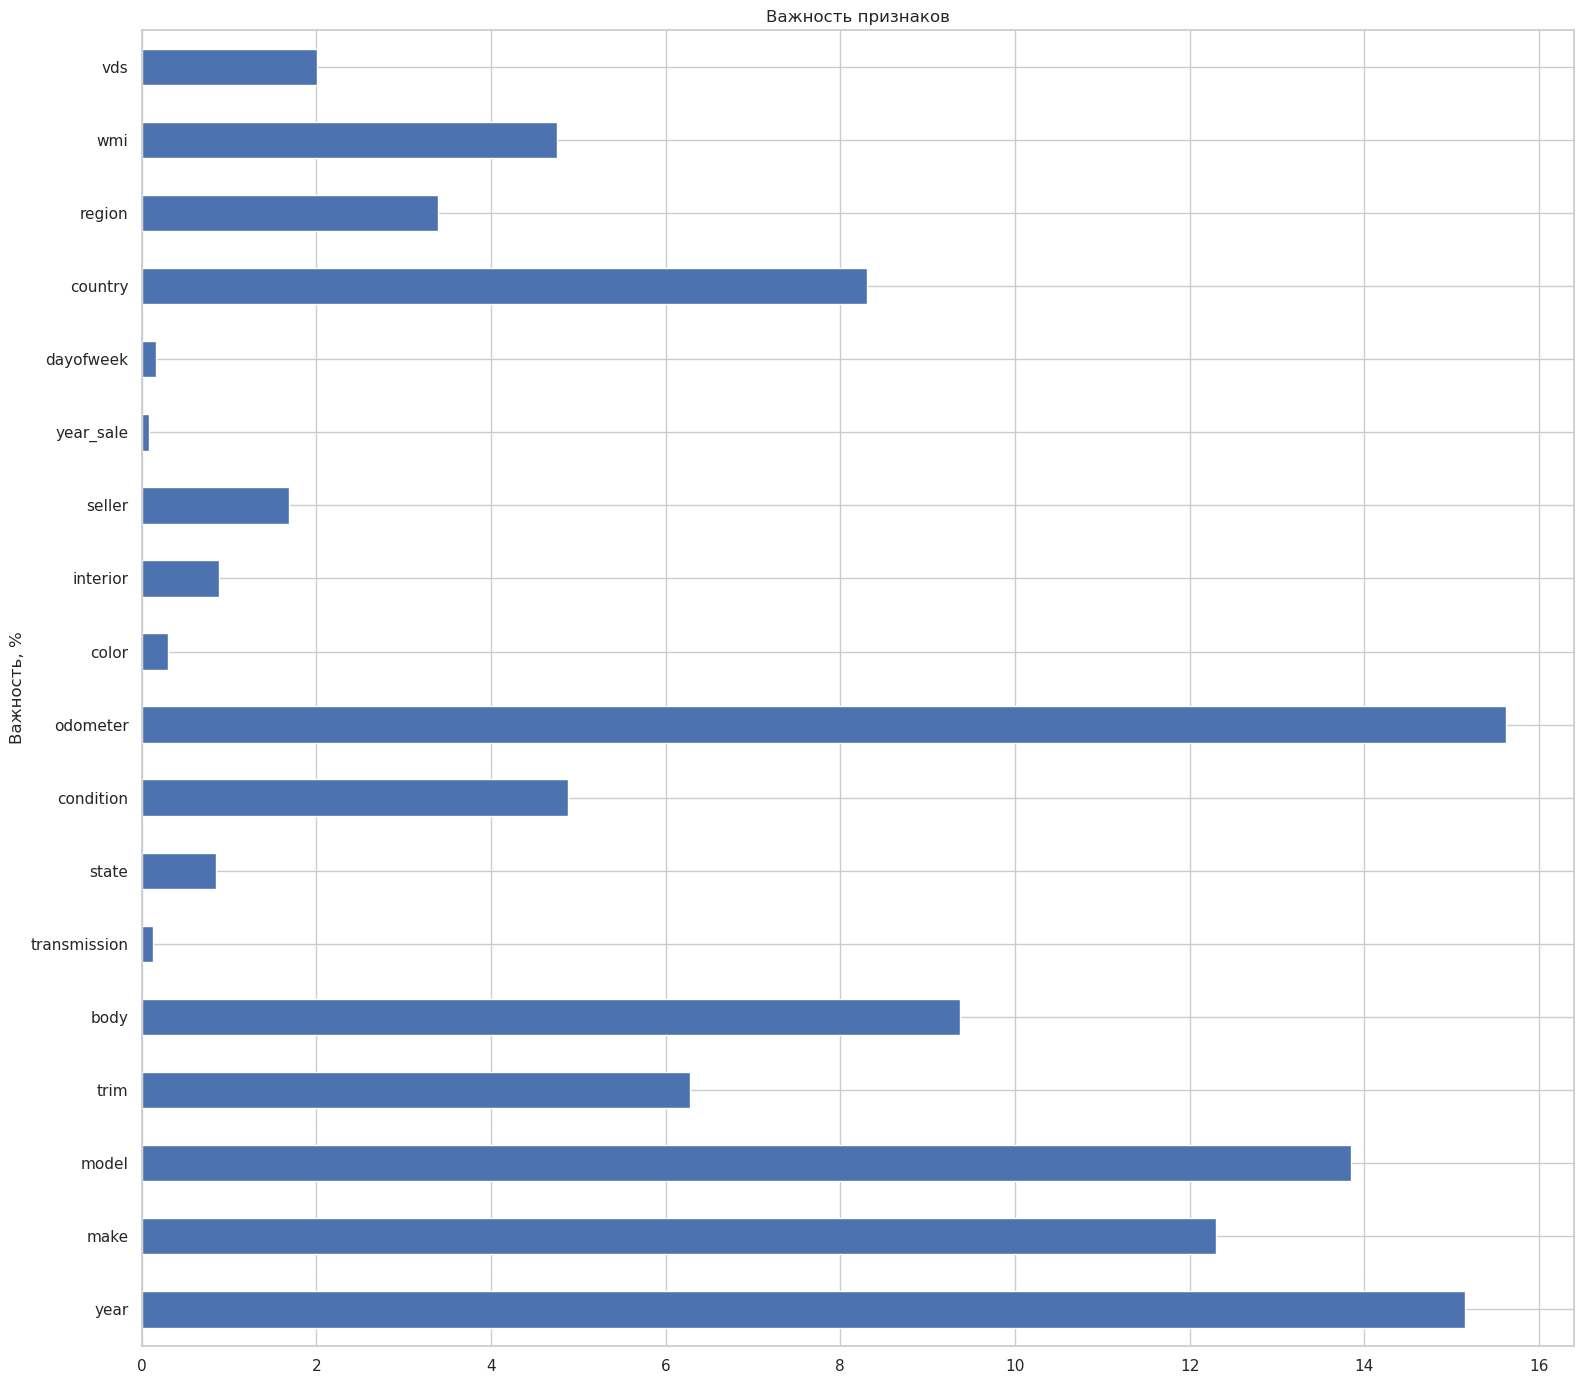

In [153]:
# обратимся к функции получения важности признаков в CatBoostRegressor
cat_imp = pd.Series(model_Cat.get_feature_importance(), features.columns)

# визуализаруем результат работы get_feature_importance
fig, ax = plt.subplots(figsize=(16,14))
cat_imp.plot.barh(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

##  **Коэффициент детерминации**

In [154]:
# оценим модель метрикой R2
print('R2 модели CatBoostRegressor на train выборке:', round(r2_score(target_valid, pred_valid_cat),2))

R2 модели CatBoostRegressor на train выборке: 0.96


**Коэффициент детерминации, R² является статистической мерой согласия, с помощью которой можно определить, насколько модель соответствует данным, на которых она построена. Мы получили коэффициент детерминации CatBoostRegressor на train выборке: 0.96, что является очень высоким значением для данной метрики.**

## **Проверка лучшей модели на адeкватность**

In [155]:
# используем для проверки на адыкватность DummyRegressor
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(features_train, target_train)
dummy_test_pred = dummy_model.predict(features_valid)
print('MAPE для DummyRegressor:',round(mean_absolute_percentage_error(target_valid, dummy_test_pred),2))

MAPE для DummyRegressor: 1.8


## **Вывод по разделу обучения моделей**
Мы построили три модели - регрессора. Линейную модель, ансамблевая модель RandomForestRegressor и модель градиентного бустинга **CatBoostRegressor**.  Две модели показали неплохие результаты.  "Наивная модель" показала метрику - 1,8. На тестовой выборке лучшая модель показала метрику - 15%, что можно считать успехом нашего проекта. Также отметим результаты дополнительного исследования важности признаков - основной вклад (более 5% каждый) в обучение внесли **7 ключевых признаков: пробег, модель, марка, год выпуска, тип кузова, страна производителя, комплектация** автомобиля. 

In [156]:
# создадим файл с предсказаниями цены для тестовой выборки
vin_price.to_csv('vin_price_7.csv',index=False)

# **Итоговый вывод**

Перед нами стояла цель - построить модель, которая предскажет стоимость автомобиля на вторичном рынкке. Исследование и подготовка данных позволила нам добится  результата - метрики МАРЕ - 15%. Возможно улучшить показатель по следующему плану:
 1) применение NLP при подготвке столбцов "модель", "тип кузова", "продавец" и "комплектация";
 
 2) РСА - метод гланых компонент;
 
 3) построение и применение нейросети. 